## Initialisation 

In [280]:
#Declaring imports
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
import xgboost as xgd


In [257]:
#Files
train_data_path = 'train.csv'
test_data_path = 'test.csv'


In [258]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)
all_data = [train_df, test_df]

In [259]:
#Renaming columns so its easier to understand
for dataset in all_data:
    dataset.rename(inplace=True, columns={'PassengerId':'Id', 'Pclass':'TicketClass', 'SibSp':'NumSiblingsSpouse', 'Parch':'NumParentsChild', 'ticket':'TicketNumber', 'Cabin':'CabinNumber', 'embarked':'PortEmbarked'})

# Exploratory Data Analysis
Seeing the rough distribution of the different columns

In [260]:
#Seeing how the dataframe is like
train_df.describe()

,Id,Survived,TicketClass,Age,NumSiblingsSpouse,NumParentsChild,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


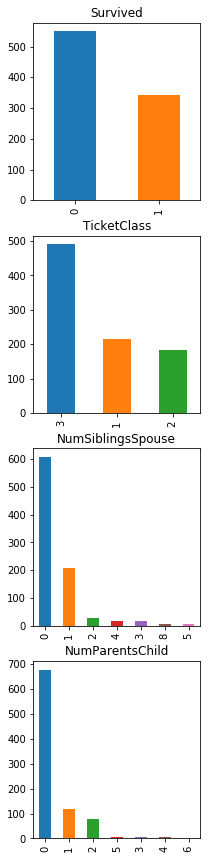

In [261]:
#Seeing the distribution of discrete data
col_list =  ['Survived', 'TicketClass', 'NumSiblingsSpouse', 'NumParentsChild']
fig, axes = plt.subplots(nrows=len(col_list), ncols=1, figsize=(3,15))
for i, col_name in enumerate(col_list):
    train_df[col_name].value_counts().plot(kind='bar', ax=axes[i], title = col_name)


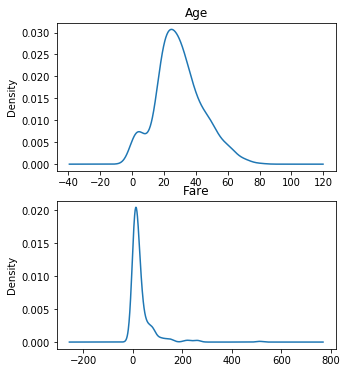

In [262]:
#Plotting continuous distributions
col_list = ['Age', 'Fare']
fig, axes = plt.subplots(nrows=len(col_list), ncols=1, figsize=(5,6))
for i, col_name in enumerate(col_list):
    train_df[col_name].plot(kind='density', ax=axes[i], title = col_name)


In [263]:
#Finding the number of null values in each column to see which column has a problem
results = {}
vals = {}
for key in train_df.keys():
    vals[key] = train_df[key].isnull().sum()
results['train'] = vals

vals = {}
for key in test_df.keys():
    vals[key] = test_df[key].isnull().sum()
results['test'] = vals
pd.DataFrame.from_dict(results, dtype=int)

,test,train
Age,86.0,177
CabinNumber,327.0,687
Embarked,0.0,2
Fare,1.0,0
Id,0.0,0
Name,0.0,0
NumParentsChild,0.0,0
NumSiblingsSpouse,0.0,0
Sex,0.0,0
Survived,NaN,0


## Seeing how the different features affect outcome

In [264]:
print(train_df[['TicketClass','Survived']].groupby(['TicketClass']).mean())

             Survived
TicketClass          
1            0.629630
2            0.472826
3            0.242363


In [265]:
print(train_df[["Sex", "Survived"]].groupby(['Sex']).mean())

        Survived
Sex             
female  0.742038
male    0.188908


In [266]:
print(train_df[["Sex","Survived"]].groupby(["Sex"]).mean())

        Survived
Sex             
female  0.742038
male    0.188908


In [267]:
for dataset in all_data:
    dataset["FamilySize"] = dataset["NumSiblingsSpouse"] + dataset["NumParentsChild"] + 1
print (train_df[['FamilySize', 'Survived']].groupby(['FamilySize']).mean())

            Survived
FamilySize          
1           0.303538
2           0.552795
3           0.578431
4           0.724138
5           0.200000
6           0.136364
7           0.333333
8           0.000000
11          0.000000


In [268]:
for dataset in all_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train_df[['IsAlone', 'Survived']].groupby(['IsAlone']).mean())

         Survived
IsAlone          
0        0.505650
1        0.303538


## Handling NA values

In [269]:
#Drop if more than a number of NA values
for dataset in all_data:
    length = len(dataset.keys())
    dataset.dropna(thresh=length-5, inplace=True)

In [270]:
#Drop the rows with NA values in embarked 
for dataset in all_data:
    dataset.dropna(subset=['Embarked'],inplace=True)

In [271]:
#There are quite alot of null values in age and cabin, so I will replace them with the most frequently occuring values
for dataset in all_data:
    dataset['Fare'] = dataset['Fare'].fillna(train_df['Fare'].median())
    dataset['Age'] = dataset['Age'].fillna(train_df['Age'].median())
    dataset['Embarked'] = dataset['Embarked'].fillna('C')

In [272]:
for dataset in all_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

# Feature Selection

In [273]:
drop_elements = ['Id', 'Name', 'Ticket', 'CabinNumber', 'NumSiblingsSpouse']
for dataset in all_data:
    dataset.drop(drop_elements, axis=1, inplace=True)

# More Visualisation

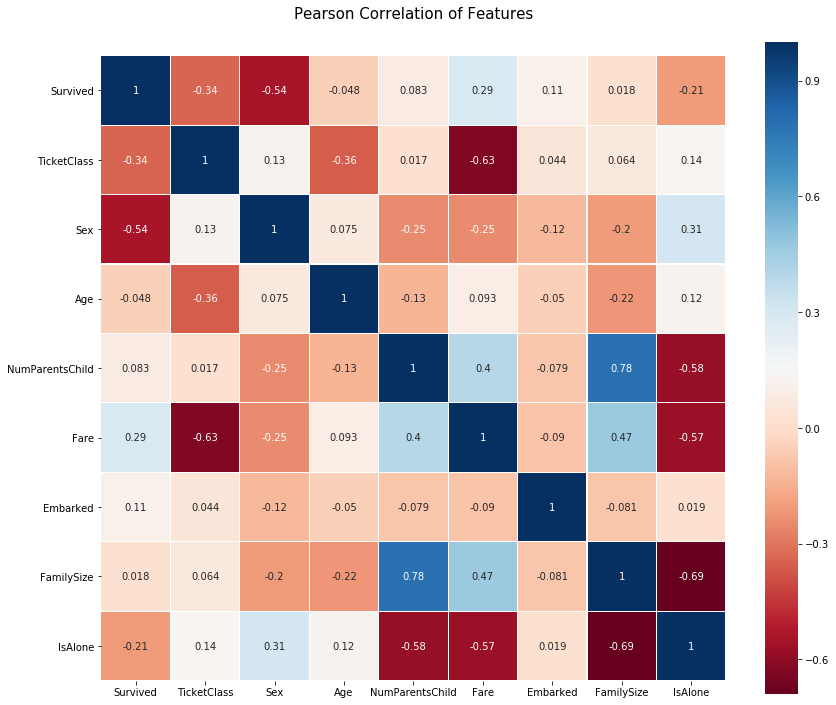

In [274]:
#Understanding correlation will help in deciding which features are important and which are not
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


In [284]:
# Initialising variables to be used for model

In [285]:
n_train = train_df.shape[0]
n_test = test_df.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_train, n_folds = NFOLDS, random_state=SEED)

In [286]:
class SklearnHelper:
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    def train(self, x_train, y_trian):
        self.clf.fit(x_train, y_train)
    def predict(self, x):
        return self.clf.predict(x)
    def fit(self, x, y):
        return self.clf.fit(x,y)
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)

In [287]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [288]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [289]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)


In [290]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

NameError: name 'train' is not defined